# Movie Reviews Analysis using Naive Bayes

In [35]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from  sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings; warnings.simplefilter('ignore')

## Introduction

In this scenario, I'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv".  I've also put a file "movies.dat" that contains metadata for ~65,000 different movies

The mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie. We'll start out with some exploratory data analysis.

---

## Descriptive analysis

Before beginning the "real" work, I dug into the data a bit do see what we're dealing with.  We begin by loading the datasets and dropping rows that have missing data:

In [36]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

### Basic features of the dataset

We try to answer the following questions:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [37]:
# Basic feature of the dataset
print("The number of unique reviews(quotes) in the reviews dataset is:",len(reviews.quote.unique()))
print("The number of unique reviewers(critics) in the reviews dataset is:",len(reviews.critic.unique()))
print("The number of unique movies in the reviews dataset is:",len(reviews.rtid.unique()))
print("The number of unique movies in the movies dataset is:",len(movies.id.unique()))
print("The number of unique publications in the reviews dataset is:",len(reviews.publication.unique()))

The number of unique reviews(quotes) in the reviews dataset is: 12814
The number of unique reviewers(critics) in the reviews dataset is: 541
The number of unique movies in the reviews dataset is: 1720
The number of unique movies in the movies dataset is: 9423
The number of unique publications in the reviews dataset is: 64


###  Number of reviews per reviewer

Using the `reviews` dataset, I created a histogram showing the distribution of the number of reviews per reviewer.  

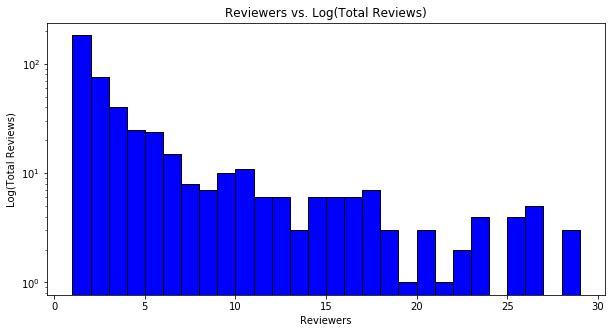

In [38]:
# Histogram to show the distribution of the number of reviews per reviewer
reviews_grouped = pd.groupby(reviews,by=reviews.critic)
reviews_grouped = reviews_grouped.count()

plt.figure(figsize=(10,5))
plt.yscale('log',nonposy = "clip")
plt.hist(reviews_grouped.fresh,bins=np.arange(1,30,1),color="Blue",edgecolor="black")
plt.title("Reviewers vs. Log(Total Reviews)")
plt.ylabel("Log(Total Reviews)")
plt.xlabel("Reviewers")
plt.show()

### Zoom in on a few reviewers
We try to find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

In [39]:
reviews_grouped = reviews_grouped.sort_values("fresh",ascending=False)
index = reviews_grouped.index[range(30)]
first_date = pd.groupby(reviews,by=reviews.critic).agg(np.min)
last_date = pd.groupby(reviews,by= reviews.critic).agg(np.max)

first=[]
last=[]
publisher = []
count = []

for i in index:
    first.append(first_date.review_date[first_date.index == i])
    last.append(last_date.review_date[last_date.index == i])
    publisher.append(reviews.publication[reviews.critic==i].max())
    count.append(reviews_grouped.fresh[reviews_grouped.index ==i])

stacked_arr = np.column_stack((index,publisher,first, last,count))  
df = pd.DataFrame(stacked_arr)  
df.columns=['Critic','Publisher','First Date','Last Date','Count']
df

,Critic,Publisher,First Date,Last Date,Count
0,Roger Ebert,Chicago Sun-Times,2000-01-01 00:00:00,2013-06-11 00:00:00,1150
1,James Berardinelli,ReelViews,1800-01-01 00:00:00,2012-02-07 00:00:00,833
2,Janet Maslin,New York Times,2000-01-01 00:00:00,2010-09-07 00:00:00,526
3,Variety Staff,Variety,2001-02-13 00:00:00,2012-08-15 00:00:00,449
4,Jonathan Rosenbaum,Chicago Reader,1988-07-11 00:00:00,2013-10-22 00:00:00,420
5,Desson Thomson,Washington Post,2000-01-01 00:00:00,2012-10-08 00:00:00,373
6,Geoff Andrew,Time Out,2005-08-11 00:00:00,2012-04-05 00:00:00,361
7,Dave Kehr,New York Daily News,2000-01-01 00:00:00,2013-11-20 00:00:00,360
8,Kenneth Turan,Los Angeles Times,2000-01-01 00:00:00,2013-10-05 00:00:00,282
9,Mick LaSalle,San Francisco Chronicle,2000-01-01 00:00:00,2009-11-25 00:00:00,280


### Ratings over time

Using the `movies` dataset, I created a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.

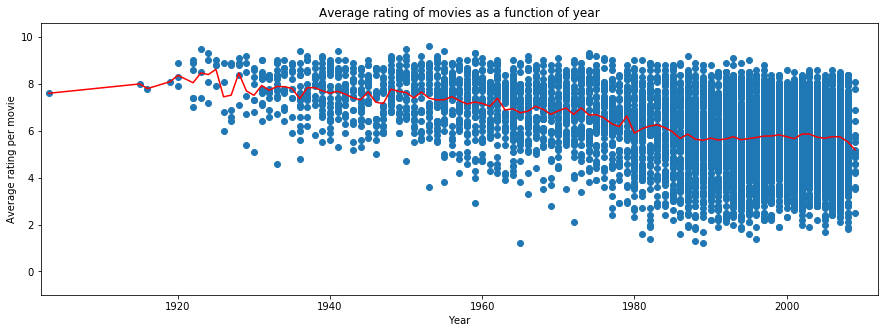

In [40]:
rating_int = pd.to_numeric(movies.rtAllCriticsRating, errors='coerce')
del movies['rtAllCriticsRating']
movies['rtAllCriticsRating'] = rating_int

plt.figure(figsize=(15,5))
plt.ylim([movies.rtAllCriticsRating.min()-1,movies.rtAllCriticsRating.max()+1])
plt.xlim([movies.year.min()-1,movies.year.max()+1])

plt.scatter(movies.year[movies.rtAllCriticsRating>0], movies.rtAllCriticsRating[movies.rtAllCriticsRating>0])

avgrating = pd.DataFrame.groupby(movies[movies.rtAllCriticsRating>0], by = movies[movies.rtAllCriticsRating>0].year).mean()


plt.plot(avgrating.index, avgrating.rtAllCriticsRating, 'red')

plt.xlabel("Year")
plt.ylabel("Average rating per movie")
plt.title("Average rating of movies as a function of year")

plt.show()

The trend of the average rating per movie seems to decline as the number of movies increases, over the years. One explanation may be that, as the number of movies increases, the overall quality of movies decreased as well. Another explanation, could be as the number of movies increased, the metophorical bar for good movies increased as well, thus increasing the expectations and standards of movies being made, and only exceptionally good movies got high ratings.  

---

## Naive Bayes

Now we use a Naive Bayes Classifier to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. 

### Using CountVectorizer

We use CountVectorizor(http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help us convert out raw text fields into "bag of words" vectors.

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print("Original text:\n", '\n'.join(text))
vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print ("Transformed text vector:\n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x
print ("Words for each feature:")
print (vectorizer.get_feature_names())

Original text:
 machine learning rocks
machine learning rules
rocks rocks rules
Transformed text vector:
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]
Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### Create  X input and Y output

Using the `reviews` dataframe, we compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 

In [42]:

def make_xy(critics, vectorizer=None):    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    Y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, Y


### Test-Train split

Next, we randomly split the data into two groups: a training set and a validation set.  

In [43]:
Input, Output = make_xy(reviews)
TrainInput,TestInput,TrainOutput,TestOutput =  train_test_split(Input,Output,train_size = 0.75, random_state=1)

### Naive Bayes with `MultinomialNB`
We use the training set to train a Naive Bayes classifier using the MultinomialNB.


In [44]:

import sklearn.naive_bayes as nb
fitted_model = nb.MultinomialNB()
fitted_model.fit(X=TrainInput,y=TrainOutput)
predTrainOutput = fitted_model.predict(TrainInput)
predTestOutput = fitted_model.predict(TestInput)

PerformanceTrain=(1-(abs(predTrainOutput-TrainOutput).sum())/float(len(TrainOutput)))*100
PerformanceTest=(1-(abs(predTestOutput-TestOutput).sum())/float(len(TestOutput)))*100

print("Performance/Accuracy on Training set: ",round(PerformanceTrain,2),"%")
print("Performace/Accuracy on Testing set: ",round(PerformanceTest,2),"%")

Performance/Accuracy on Training set:  92.61 %
Performace/Accuracy on Testing set:  78.03 %


The model seems to perform quite well on the training set, having a 92% accuracy. However, when the model is appied to the test set, the accuracy goes down to 78%. This means the model doesnt seem to be able generalize the results well, an may be overfitting on the training set, which could explain it's low performance on the test set.  

---

## Evaluation

### Estimate the likelihood of our data

Given a fitted model, we can compute the log-likelihood of our data as a way to assess the performance of your model. 

In [45]:


def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

ll_train = log_likelihood(fitted_model,TrainInput,TrainOutput)
ll_test = log_likelihood(fitted_model,TestInput,TestOutput)


print('Log-Likelihood on Training dataset: ' ,ll_train)
print('Log-Likelihood on Testing dataset: ' ,ll_test)

Log-Likelihood on Training dataset:  -1879.8528684
Log-Likelihood on Testing dataset:  -1860.30332749


### Cross-Validation


Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

The objective function we want to maximize is the log-likelihood of our data. We loop over many values of `alpha` and `min_df` to determine which settings are "best" in the sense of maximizing the cross-validated log-likelihood.


In [46]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf
            
for a in alphas:
    for m in min_dfs:
        vector = CountVectorizer(min_df = m)
        Input, Output = make_xy(reviews, vector)
        s = cross_val_score(nb.MultinomialNB(alpha=a).fit(Input,Output), Input,Output,cv=5, scoring=log_likelihood).mean()
        if s > max_loglike:
            max_loglike = s
            best_alpha = a
            best_min_df = m
            
print("Maximum value of log-likelihood achieved:",max_loglike)
print("Value of 'alpha' that maximizes log-likelihood:",best_alpha)
print("Value of 'min_df' that maximizes log-likelihood:",best_min_df)


Maximum value of log-likelihood achieved: -1468.44843088
Value of 'alpha' that maximizes log-likelihood: 5
Value of 'min_df' that maximizes log-likelihood: 0.001


### Putting it together

Now that we've determined values for alpha and min_df that optimize the cross-validated log-likelihood, we repeat the steps to train a final classifier with these parameters and re-evaluate the accuracy.  

In [47]:
def make_xy_1(reviews, min_df, vectorizer=None):
    temp = reviews.quote
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df=min_df)
    X = vectorizer.fit_transform(temp)
    Y = (reviews.fresh=='fresh').values.astype(np.int)
    ## Stores all words in 'names' array for further use
    names = np.array(vectorizer.get_feature_names())
    return X, Y,names



Input_1,Output_1, names = make_xy_1(reviews,best_min_df)

train_Input_1, test_Input_1,train_Output_1, test_Output_1 = train_test_split(Input_1,Output_1)

model_1 = nb.MultinomialNB(alpha=best_alpha)

model_1.fit(train_Input_1,train_Output_1)

print('Accuracy on training set is =',(1-(abs(model_1.predict(train_Input_1)-train_Output_1).sum())/float(len(train_Output_1)))*100,'%')

print('Accuracy on testing set is =',(1-(abs(model_1.predict(test_Input_1)-test_Output_1).sum())/float(len(test_Output_1)))*100,'%')

print(log_likelihood(model_1, train_Input_1, train_Output_1))
print(log_likelihood(model_1, test_Input_1, test_Output_1))

Accuracy on training set is = 78.9546899841 %
Accuracy on testing set is = 74.9329359165 %
-4473.1449858
-1764.63644583


As a result of overfitting due to cross-validation, the model's performance seem to have substantially deteriorated. The model's accuracy for the training set, decreased from 92% to 78.8%, while the performance on the test set decreased from 78% to 74.5%. 


### Classification Accuracy
What happens if we tried this again using a function besides the log-likelihood -- i.e., the classification accuracy.

In [48]:
from sklearn.metrics import mean_squared_error, accuracy_score

best_alpha_1 = None
best_min_df_1 = None
max_accuracy_1=0

for a in alphas:
    for m in min_dfs:         
        vectorizer_1 = CountVectorizer(min_df = m)       
        Input_temp, Output_temp = make_xy(reviews, vectorizer_1)
        fitted_model_temp = MultinomialNB(alpha=a).fit(Input_temp, Output_temp)
        s_1 = cross_val_score(fitted_model_temp,Input_temp, Output_temp,cv=10, scoring='accuracy').mean()
        if s_1 > max_accuracy_1:
            max_accuracy_1=s_1
            best_alpha_1 = a
            best_min_df_1 = m
            
print("Value of 'alpha' :",best_alpha_1)
print("Value of 'min_df' :",best_min_df_1)

vectorizer_final = CountVectorizer(min_df=best_min_df_1)
Input_final, Output_final = make_xy(reviews, vectorizer_final)

Input_train_final,Input_test_final,Output_train_final,Output_test_final = train_test_split(Input_final, Output_final,
                                                                                                 test_size = 0.33,
                                                                                                 random_state = 42)
fitted_model_final = MultinomialNB(alpha=best_alpha_1)

fitted_model_final.fit(Input_train_final,Output_train_final)

predicted_fresh_final = fitted_model_final.predict(Input_test_final)

print("Accuracy Score of Model on Training Set =",(1-(abs(fitted_model_final.predict(Input_train_final)-Output_train_final).sum())/float(len(Output_train_final)))*100,'%')

print("Accuracy Score of Model on Testing Set =",accuracy_score(Output_test_final,predicted_fresh_final)*100,'%')



Value of 'alpha' : 1
Value of 'min_df' : 1e-05
Accuracy Score of Model on Training Set = 92.3804226919 %
Accuracy Score of Model on Testing Set = 77.9182659743 %


The values of alpha and min_df changed on trying to maximize classification accuracy. The model seems to have performed better when we tried to maximize loglikelihood, as the acuuarcy on training as well as test set increased. 

### Interpretation

We check what words best predict a fresh or rotten review?  Using our classifier and the `vectorizer.get_feature_names` method, we determine which words best predict a positive or negative review. 


In [49]:
from pandas import DataFrame
id_matrix = np.identity(test_Input_1.shape[1])
p = model_1.predict_proba(id_matrix)[:,0]
index = np.argsort(p)
positive_words = names[index[:10]]
positive_prob = 1 - p[index[:10]]
positive = {'Word':positive_words, 'Probability': positive_prob}
positive = DataFrame(data = positive)


negative_words = names[index[-10:]]
negative_prob = p[index[-10:]]
negative = {'word':negative_words, 'probability':negative_prob} 
negative = DataFrame(data = negative)

print('Positive review ')
print(positive)
print('Negative review-')
print(negative)

Positive review 
   Probability         Word
0     0.883901      complex
1     0.880910  masterpiece
2     0.875925      delight
3     0.865948         rare
4     0.864451     touching
5     0.861670        witty
6     0.857579     intimate
7     0.850968  intelligent
8     0.849913       moving
9     0.843714        gives
Negative review-
   probability            word
0     0.765266         problem
1     0.771235         unfunny
2     0.776167        tiresome
3     0.785420      uninspired
4     0.786888          stupid
5     0.786888  disappointment
6     0.793938           bland
7     0.822174       pointless
8     0.828064            lame
9     0.855906   unfortunately


From the list above we can see that the words, that predict a positive review, are words like 'masterpiece', 'beautiful', and 'delight'. But these are words, that  can mean a bad review as well in context of what they are written in, and can all have negative connotations. The same can be said for the words that predict negative reviews as well, like 'dull' and 'sadly', which could both have positive connotations.

### Error Analysis

Naive Bayes classifiers assume that every word affects the probability independently of other words. We check in what way is this a bad assumption. We check the classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [50]:
prob = model_1.predict_proba(Input_1)[:, 0]
predict = model_1.predict(Input_1)

poor_negative = np.argsort(prob[Output_1 == 0])[:5]
poor_positive = np.argsort(prob[Output_1 == 1])[-5:]

print("Mismatched quotes in rotten category:")
count = 0;

for row in poor_negative:
    count += 1
    print(str(count) + ". " + reviews[Output_1 == 0].quote.iloc[row])
    print('\n')

print('\n')
print ("Mismatched quotes in fresh category:")
print
count = 0;
for row in poor_positive:
    count += 1
    print(str(count) + ". " + reviews[Output_1 == 1].quote.iloc[row])
    print('\n')

Mismatched quotes in rotten category:
1. The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece.


2. The Disney organization is worst when it makes "family entertainment" and best when it sticks to pure, simple, charming fantasy.


3. It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.


4. It's a sad day when an actor who's totally, beautifully in touch with his dark side finds himself stuck in a movie that's scared of its own shadow.


5. Irons gives an excruciating performance - what Streep's genuinely warm, wonderful Clara sees in him you'd need ESP to fathom.




Mismatched quotes in fresh category:
1. There's too much talent and too strong a story to mess it up. There was potential for more here, but this incarnation is nothing to be ashamed of, a

In [51]:
input_quote = 'This movie is not remarkable, touching, or superb in any way'

# The string needs to be converted to a series, so that we can apply the vectorize transform function
input_series = pd.Series(input_quote)

# Initialize vectorizer
vectorizer = CountVectorizer(min_df=best_min_df)

# Fitting our Data of quotes
vectorizer.fit(reviews.quote)

# Transform our input string
X = vectorizer.transform(input_series)

# Probability of freshness
print ('Input String: ',input_quote)
print('Freshness Probability:',np.around(1 - float(model_1.predict_proba(X)[:,0]),3))

Input String:  This movie is not remarkable, touching, or superb in any way
Freshness Probability: 0.97


In Naive Bayes, the assumption is that every word affects the probabilty independendently. This is not a good assumption, as the context and connotations of the word is lost. As seen in the example above, by addding the word "not" before the words - remarkable, superb and touching, the context changes, and makes it a negative review, but as Naive Bayes only looks at the individual words, it returns a freshness probabaility of 97%, which is obviously incorrect. 